In [1]:
import json
import os

import tqdm
import datetime
import pytz
import numpy

import pandas

import scipy.stats
import sklearn.svm
import sklearn.ensemble
import math

%matplotlib widget
import matplotlib
import matplotlib.pyplot

import seaborn

# General settings and experiment location

In [2]:
source_computer = 'beetle'
REAGGLOMERATE_FLAG = False
RECALCULATION_FLAG = True
WR_CONFIDENCE       = 0.50
LIMIT_DATE_SETUP_START  = pytz.utc.localize(datetime.datetime(2023,7,17))
LIMIT_DATE_EXP          = pytz.utc.localize(datetime.datetime(2023,7,29))
LIMIT_DATE_SETUP_STOP   = pytz.utc.localize(datetime.datetime(2023,8,1))
root_path = '/Users/matthieu/.ssh/ssh_to_graz/saved_graz_data/' + source_computer + '/metadata/'
data_path = root_path + '/'
conf_path = root_path + '../config/'

actuation_ratios = pandas.read_pickle(conf_path + 'processed_actuation_phases.pickle')

days_to_discard_str = ['23/07/22', '23/07/25', '23/07/20']#, '23/07/24', '23/07/26']
days_to_discard = [pytz.utc.localize(datetime.datetime.strptime(x, '%y/%m/%d')).date() for x in days_to_discard_str]

pfiles = sorted([f for f in os.listdir(data_path) if f.endswith('.pickle')])
# print(pfiles)

# Waggle runs gathering and cleaning

In [3]:
# Gather waggles
if REAGGLOMERATE_FLAG : 
    all_waggles_df = []
    for id_f, f in enumerate(pfiles) :
        if id_f == 0:
            all_waggles_df = pandas.read_pickle(data_path + f)
            continue

        meta_df = pandas.read_pickle(data_path + f)
        all_waggles_df = pandas.concat((all_waggles_df, meta_df), ignore_index=True)
    pandas.to_pickle(all_waggles_df, root_path+'all_waggles.pickle')
else :
    all_waggles_df = pandas.read_pickle(root_path+'all_waggles.pickle')

# Clean dataframe
all_waggles_df = all_waggles_df[~all_waggles_df.isnull().any(axis=1)]

# Comb config processing : experiments times

In [4]:
# load config file
with open(conf_path+'comb_config.json', "r") as f:
    exp_configuration = json.load(f)

exp_configs = [[]]*len(exp_configuration['experiment']['timeslots'])
for conf_id, conf in enumerate(exp_configuration['experiment']['timeslots']):
    exp_config = conf
    exp_config['dtts_start'] = datetime.datetime.fromisoformat(conf["from"])
    exp_config['dtts_stop'] = datetime.datetime.fromisoformat(conf["to"])
    exp_configs[conf_id] = exp_config

exp_configs = pandas.DataFrame.from_records(exp_configs).tail(-1) # remove first row --> default configuration

## Effect of the vibrations on the number of waggle runs for the 2 hours experiments : Processing

In [5]:
DURATION_EXPERIMENT_2H = datetime.timedelta(minutes=10.0)
results = []
range_bins = range(-12,12)

for exp_i, exp in exp_configs.iterrows():
    # print(exp)
    res = dict(exp)

    if exp['dtts_start'] < LIMIT_DATE_SETUP_START or exp['dtts_start'] > LIMIT_DATE_EXP :
        continue

    if exp['dtts_start'].date() in days_to_discard :
        continue
    
    for i_bin in range_bins:
        if exp.rule == 'vibrate':
            res['type'] = 'exp'
            vibs_start_time = exp['dtts_start'] + DURATION_EXPERIMENT_2H*i_bin
            vibs_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT_2H*(i_bin+1)
        elif exp.rule == 'no_vibrate':
            res['type'] = 'blank'
            vibs_start_time = exp['dtts_start'] + DURATION_EXPERIMENT_2H*i_bin
            vibs_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT_2H*(i_bin+1)
        

        # Naively take all of the waggles and count them
        vibs_runs = all_waggles_df[all_waggles_df.timestamp_begin > vibs_start_time]
        vibs_runs = vibs_runs[vibs_runs.timestamp_begin < vibs_stop_time]

        # Take only the waggles with high confidence and count them
        vibs_runs_confidence = vibs_runs[vibs_runs.label_confidence > WR_CONFIDENCE]

        # Compare waggle runs that we want to inhibit with others
        target_angle            = exp.angle_deg
        vibs_runs_targeted      = vibs_runs_confidence[abs((vibs_runs_confidence.dance_world_angle_deg)%360-target_angle) < 90]

        res['Ccount_'+str(i_bin)] = len(vibs_runs_confidence)
        res['Tcount_'+str(i_bin)] = len(vibs_runs_targeted)


    results.append(res)

results_2h             = pandas.DataFrame.from_dict(results)
results_2h['count_exp']  = range(1, len(results_2h)+1)
results_2h

,from,to,rule,dtts_start,dtts_stop,angle_deg,type,Ccount_-12,Tcount_-12,Ccount_-11,...,Tcount_7,Ccount_8,Tcount_8,Ccount_9,Tcount_9,Ccount_10,Tcount_10,Ccount_11,Tcount_11,count_exp
0,2023-07-17T09:10:00+02:00,2023-07-17T11:10:00+02:00,no_vibrate,2023-07-17 09:10:00+02:00,2023-07-17 11:10:00+02:00,314.0,blank,0,0,0,...,560,874,790,792,470,782,624,998,638,1
1,2023-07-17T11:10:00+02:00,2023-07-17T13:10:00+02:00,vibrate,2023-07-17 11:10:00+02:00,2023-07-17 13:10:00+02:00,314.0,exp,728,450,504,...,0,54,8,64,54,132,68,172,106,2
2,2023-07-17T16:40:00+02:00,2023-07-17T18:40:00+02:00,vibrate,2023-07-17 16:40:00+02:00,2023-07-17 18:40:00+02:00,314.0,exp,0,0,0,...,108,464,86,542,72,172,96,144,82,3
3,2023-07-18T09:10:00+02:00,2023-07-18T11:10:00+02:00,vibrate,2023-07-18 09:10:00+02:00,2023-07-18 11:10:00+02:00,314.0,exp,0,0,0,...,142,196,92,224,64,262,144,226,148,4
4,2023-07-18T11:40:00+02:00,2023-07-18T13:40:00+02:00,no_vibrate,2023-07-18 11:40:00+02:00,2023-07-18 13:40:00+02:00,314.0,blank,248,112,320,...,74,94,34,88,44,222,80,150,36,5
5,2023-07-19T10:00:00+02:00,2023-07-19T12:00:00+02:00,no_vibrate,2023-07-19 10:00:00+02:00,2023-07-19 12:00:00+02:00,314.0,blank,0,0,0,...,330,1002,358,924,550,596,326,1022,308,6
6,2023-07-19T12:10:00+02:00,2023-07-19T14:10:00+02:00,no_vibrate,2023-07-19 12:10:00+02:00,2023-07-19 14:10:00+02:00,314.0,blank,928,284,1340,...,276,358,224,436,300,484,314,634,416,7
7,2023-07-19T14:20:00+02:00,2023-07-19T16:20:00+02:00,vibrate,2023-07-19 14:20:00+02:00,2023-07-19 16:20:00+02:00,314.0,exp,560,222,658,...,102,186,68,236,138,138,102,332,96,8
8,2023-07-21T09:20:00+02:00,2023-07-21T11:20:00+02:00,no_vibrate,2023-07-21 09:20:00+02:00,2023-07-21 11:20:00+02:00,314.0,blank,0,0,6,...,392,842,500,332,256,978,632,1010,524,9
9,2023-07-21T12:15:00+02:00,2023-07-21T14:15:00+02:00,no_vibrate,2023-07-21 12:15:00+02:00,2023-07-21 14:15:00+02:00,314.0,blank,396,292,508,...,274,344,242,1242,570,946,624,732,494,10


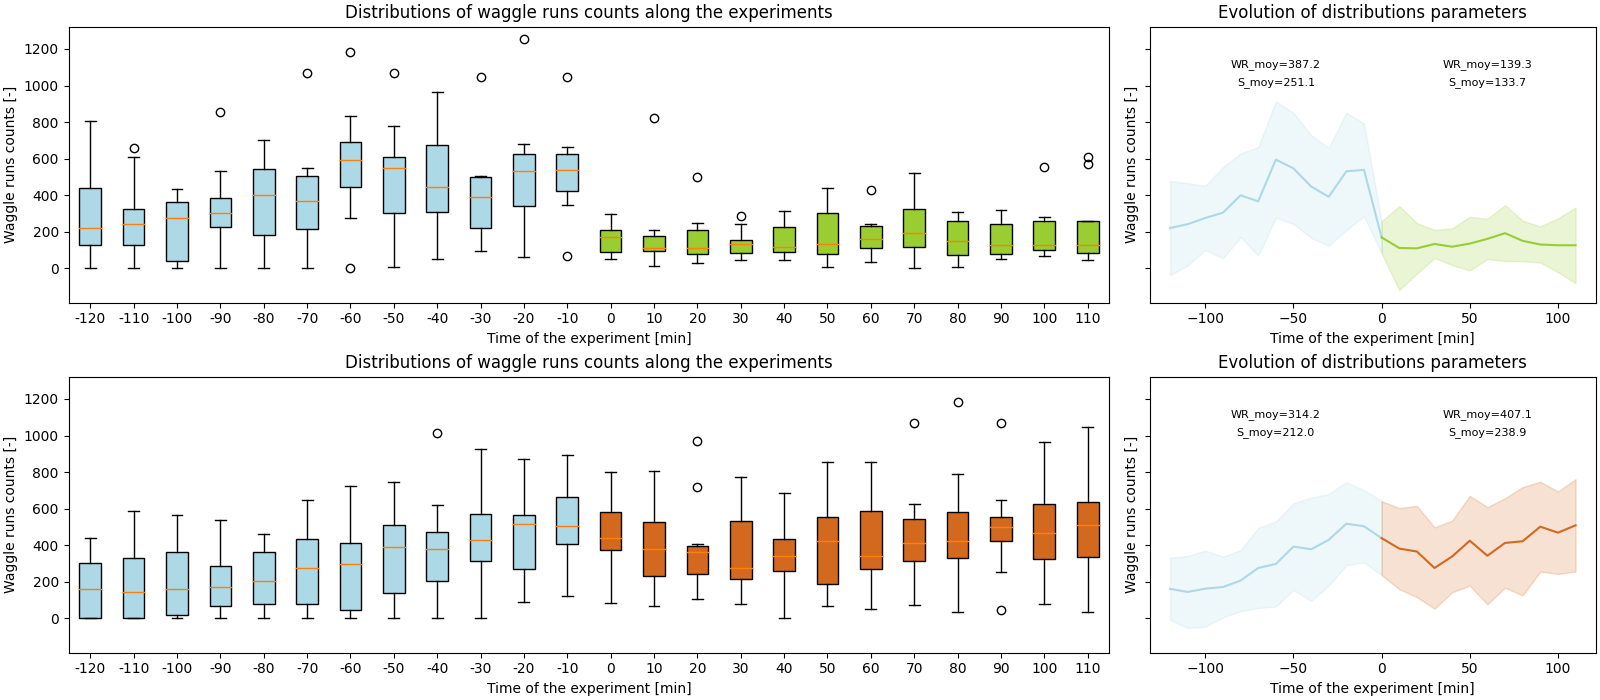

In [39]:
fig, ax = matplotlib.pyplot.subplots(2, 2, figsize=(16,7), height_ratios=[30, 30], width_ratios=[70, 30], constrained_layout=True, sharey=True)

MINUTES_BIN     = 10

COLOR_REFERENCE = 'lightblue'
COLOR_CONTROL   = 'chocolate'
COLOR_VIBS      = 'yellowgreen'

bp_vibs = [results_2h[results_2h.type=='exp']['Tcount_'+str(i)] for i in range_bins]
bp_ctrl = [results_2h[results_2h.type=='blank']['Tcount_'+str(i)] for i in range_bins]

bplot = ax[0,0].boxplot(bp_vibs, labels=numpy.array(range_bins)*MINUTES_BIN, patch_artist=True)
_ = [bp.set_facecolor(COLOR_REFERENCE) for bp_i, bp in enumerate(bplot['boxes']) if bp_i-12<0]
_ = [bp.set_facecolor(COLOR_VIBS) for bp_i, bp in enumerate(bplot['boxes']) if bp_i-12>=0]
bplot = ax[1,0].boxplot(bp_ctrl, labels=numpy.array(range_bins)*MINUTES_BIN, patch_artist=True)
_ = [bp.set_facecolor(COLOR_REFERENCE) for bp_i, bp in enumerate(bplot['boxes']) if bp_i-12<0]
_ = [bp.set_facecolor(COLOR_CONTROL) for bp_i, bp in enumerate(bplot['boxes']) if bp_i-12>=0]

ref_exp = numpy.array([[i, results_2h[results_2h.type=='exp']['Tcount_'+str(i)].median()] for i in range_bins if i<=0])
tre_exp = numpy.array([[i, results_2h[results_2h.type=='exp']['Tcount_'+str(i)].median()] for i in range_bins if i>=0])
ref_blank = numpy.array([[i, results_2h[results_2h.type=='blank']['Tcount_'+str(i)].median()] for i in range_bins if i<=0])
tre_blank = numpy.array([[i, results_2h[results_2h.type=='blank']['Tcount_'+str(i)].median()] for i in range_bins if i>=0])

_ = ax[0,1].plot(MINUTES_BIN*ref_exp[:,0], ref_exp[:,1], c=COLOR_REFERENCE)
_ = ax[1,1].plot(MINUTES_BIN*ref_blank[:,0], ref_blank[:,1], c=COLOR_REFERENCE)
_ = ax[0,1].plot(MINUTES_BIN*tre_exp[:,0], tre_exp[:,1], c=COLOR_VIBS)
_ = ax[1,1].plot(MINUTES_BIN*tre_blank[:,0], tre_blank[:,1], c=COLOR_CONTROL)

std_ref_exp = numpy.array([results_2h[results_2h.type=='exp']['Tcount_'+str(i)].std() for i in range_bins if i<=0])
std_tre_exp = numpy.array([results_2h[results_2h.type=='exp']['Tcount_'+str(i)].std() for i in range_bins if i>=0])
std_ref_blank = numpy.array([results_2h[results_2h.type=='blank']['Tcount_'+str(i)].std() for i in range_bins if i<=0])
std_tre_blank = numpy.array([results_2h[results_2h.type=='blank']['Tcount_'+str(i)].std() for i in range_bins if i>=0])

_ = ax[0,1].fill_between(MINUTES_BIN*ref_exp[:,0], ref_exp[:,1]-std_ref_exp, ref_exp[:,1]+std_ref_exp, color=COLOR_REFERENCE, alpha=0.2)
_ = ax[1,1].fill_between(MINUTES_BIN*ref_blank[:,0], ref_blank[:,1]-std_ref_blank, ref_blank[:,1]+std_ref_blank, color=COLOR_REFERENCE, alpha=0.2)
_ = ax[0,1].fill_between(MINUTES_BIN*tre_exp[:,0], tre_exp[:,1]-std_tre_exp, tre_exp[:,1]+std_tre_exp, color=COLOR_VIBS, alpha=0.2)
_ = ax[1,1].fill_between(MINUTES_BIN*tre_blank[:,0], tre_blank[:,1]-std_tre_blank, tre_blank[:,1]+std_tre_blank, color=COLOR_CONTROL, alpha=0.2)

_ = ax[0,1].text(-6*MINUTES_BIN, 1100, 'WR_moy={:1.1f}'.format(numpy.mean(ref_exp[:,1])), fontsize=8, horizontalalignment='center', color='k')
_ = ax[0,1].text(-6*MINUTES_BIN, 1000, 'S_moy={:1.1f}'.format(numpy.mean(std_ref_exp)), fontsize=8, horizontalalignment='center', color='k')
_ = ax[0,1].text(6*MINUTES_BIN, 1100, 'WR_moy={:1.1f}'.format(numpy.mean(tre_exp[:,1])), fontsize=8, horizontalalignment='center', color='k')
_ = ax[0,1].text(6*MINUTES_BIN, 1000, 'S_moy={:1.1f}'.format(numpy.mean(std_tre_exp)), fontsize=8, horizontalalignment='center', color='k')

_ = ax[1,1].text(-6*MINUTES_BIN, 1100, 'WR_moy={:1.1f}'.format(numpy.mean(ref_blank[:,1])), fontsize=8, horizontalalignment='center', color='k')
_ = ax[1,1].text(-6*MINUTES_BIN, 1000, 'S_moy={:1.1f}'.format(numpy.mean(std_ref_blank)), fontsize=8, horizontalalignment='center', color='k')
_ = ax[1,1].text(6*MINUTES_BIN, 1100, 'WR_moy={:1.1f}'.format(numpy.mean(tre_blank[:,1])), fontsize=8, horizontalalignment='center', color='k')
_ = ax[1,1].text(6*MINUTES_BIN, 1000, 'S_moy={:1.1f}'.format(numpy.mean(std_tre_blank)), fontsize=8, horizontalalignment='center', color='k')

# Titles
_ = ax[0,0].title.set_text('Distributions of waggle runs counts along the experiments')
_ = ax[0,1].title.set_text('Evolution of distributions parameters')
_ = ax[1,0].title.set_text('Distributions of waggle runs counts along the experiments')
_ = ax[1,1].title.set_text('Evolution of distributions parameters')

# xlabels
_ = ax[0,0].set_xlabel('Time of the experiment [min]')
_ = ax[0,1].set_xlabel('Time of the experiment [min]')
_ = ax[1,0].set_xlabel('Time of the experiment [min]')
_ = ax[1,1].set_xlabel('Time of the experiment [min]')

# ylabels
_ = ax[0,0].set_ylabel('Waggle runs counts [-]')
_ = ax[0,1].set_ylabel('Waggle runs counts [-]')
_ = ax[1,0].set_ylabel('Waggle runs counts [-]')
_ = ax[1,1].set_ylabel('Waggle runs counts [-]')


Feature Importances: [0.81468468 0.18531532]


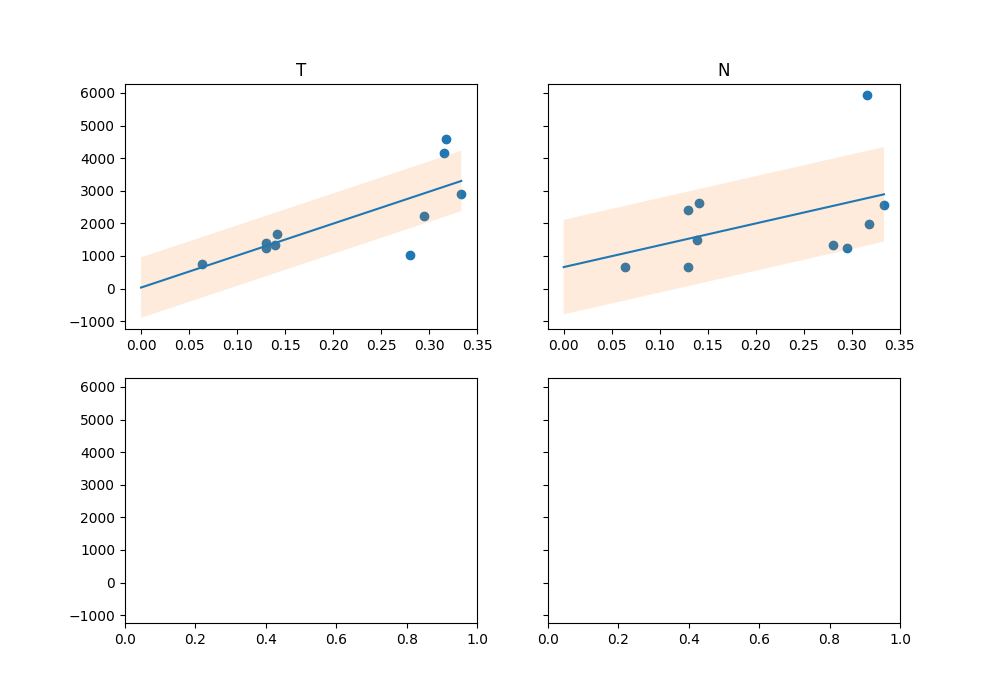

In [50]:
results_actuation = results_2h.copy()

T_wr_averages = []
NT_wr_averages = []
ratios = []
for row_id, row in results_actuation.iterrows():
    actuation_ratio = actuation_ratios[actuation_ratios.ts_start == row['from']].ratio.values
    if len(actuation_ratio) == 0:
        actuation_ratio = [0]
    ratios.append(actuation_ratio[0])
    T_wr_ave = numpy.sum(numpy.array([row['Tcount_'+str(i)] for i in range_bins if i >= 0]))
    NT_wr_ave = numpy.sum(numpy.array([row['Ccount_'+str(i)]-row['Tcount_'+str(i)] for i in range_bins if i >= 0]))
    T_wr_averages.append(T_wr_ave)
    NT_wr_averages.append(NT_wr_ave)

results_actuation['ratios'] = ratios
results_actuation['Tvibs_sum'] = T_wr_averages
results_actuation['NTvibs_sum'] = NT_wr_averages
# results_actuation

fig, ax = matplotlib.pyplot.subplots(2, 2, figsize=(10,7), sharey=True)
_ = ax[0,0].scatter(results_actuation[results_actuation.type=='exp'].ratios, results_actuation[results_actuation.type=='exp'].Tvibs_sum)
_ = ax[0,1].scatter(results_actuation[results_actuation.type=='exp'].ratios, results_actuation[results_actuation.type=='exp'].NTvibs_sum)

# Regression lines
coeffs_T, res_T, _, _, _    = numpy.polyfit(results_actuation[results_actuation.type=='exp'].ratios, results_actuation[results_actuation.type == 'exp'].Tvibs_sum, 1, full=True)
coeffs_N, res_N, _, _, _    = numpy.polyfit(results_actuation[results_actuation.type=='exp'].ratios, results_actuation[results_actuation.type == 'exp'].NTvibs_sum, 1, full=True)

x_regressions = numpy.linspace(0, results_actuation[results_actuation.type=='exp'].ratios.max())
std_T   = math.sqrt(res_T/(len(results_actuation[results_actuation.type == 'exp'].Tvibs_sum)-2))
std_N   = math.sqrt(res_N/(len(results_actuation[results_actuation.type == 'exp'].NTvibs_sum)-2))

y_T     = coeffs_T[0]*x_regressions+coeffs_T[1]
y_N     = coeffs_N[0]*x_regressions+coeffs_N[1]

_ = ax[0,0].plot(x_regressions, y_T)
_ = ax[0,1].plot(x_regressions, y_N)

_ = ax[0,0].fill_between(x_regressions, y_T-std_T, y_T+std_T, alpha=0.15)#, label='Active suppression STD regression')
_ = ax[0,1].fill_between(x_regressions, y_N-std_N, y_N+std_N, alpha=0.15)#, label='Control STD regression')

_ = ax[0,0].title.set_text('T')
_ = ax[0,1].title.set_text('N')


X = results_actuation[results_actuation.type == 'exp'][['Tvibs_sum', 'NTvibs_sum']]
y = results_actuation[results_actuation.type == 'exp']['ratios']
model = sklearn.ensemble.RandomForestRegressor()
model.fit(X, y)
feature_importances = model.feature_importances_
print("Feature Importances:", feature_importances)

In [47]:
results_actuation

,from,to,rule,dtts_start,dtts_stop,angle_deg,type,Ccount_-12,Tcount_-12,Ccount_-11,...,Ccount_9,Tcount_9,Ccount_10,Tcount_10,Ccount_11,Tcount_11,count_exp,ratios,Tvibs_ave,Cvibs_ave
0,2023-07-17T09:10:00+02:00,2023-07-17T11:10:00+02:00,no_vibrate,2023-07-17 09:10:00+02:00,2023-07-17 11:10:00+02:00,314.0,blank,0,0,0,...,792,470,782,624,998,638,1,0.000000,6738,9436
1,2023-07-17T11:10:00+02:00,2023-07-17T13:10:00+02:00,vibrate,2023-07-17 11:10:00+02:00,2023-07-17 13:10:00+02:00,314.0,exp,728,450,504,...,64,54,132,68,172,106,2,0.063577,764,1438
2,2023-07-17T16:40:00+02:00,2023-07-17T18:40:00+02:00,vibrate,2023-07-17 16:40:00+02:00,2023-07-17 18:40:00+02:00,314.0,exp,0,0,0,...,542,72,172,96,144,82,3,0.129820,1402,3804
3,2023-07-18T09:10:00+02:00,2023-07-18T11:10:00+02:00,vibrate,2023-07-18 09:10:00+02:00,2023-07-18 11:10:00+02:00,314.0,exp,0,0,0,...,224,64,262,144,226,148,4,0.139186,1332,2826
4,2023-07-18T11:40:00+02:00,2023-07-18T13:40:00+02:00,no_vibrate,2023-07-18 11:40:00+02:00,2023-07-18 13:40:00+02:00,314.0,blank,248,112,320,...,88,44,222,80,150,36,5,0.000000,826,1836
5,2023-07-19T10:00:00+02:00,2023-07-19T12:00:00+02:00,no_vibrate,2023-07-19 10:00:00+02:00,2023-07-19 12:00:00+02:00,314.0,blank,0,0,0,...,924,550,596,326,1022,308,6,0.000000,3996,11702
6,2023-07-19T12:10:00+02:00,2023-07-19T14:10:00+02:00,no_vibrate,2023-07-19 12:10:00+02:00,2023-07-19 14:10:00+02:00,314.0,blank,928,284,1340,...,436,300,484,314,634,416,7,0.000000,2946,5774
7,2023-07-19T14:20:00+02:00,2023-07-19T16:20:00+02:00,vibrate,2023-07-19 14:20:00+02:00,2023-07-19 16:20:00+02:00,314.0,exp,560,222,658,...,236,138,138,102,332,96,8,0.280288,1032,2378
8,2023-07-21T09:20:00+02:00,2023-07-21T11:20:00+02:00,no_vibrate,2023-07-21 09:20:00+02:00,2023-07-21 11:20:00+02:00,314.0,blank,0,0,6,...,332,256,978,632,1010,524,9,0.000000,5088,8334
9,2023-07-21T12:15:00+02:00,2023-07-21T14:15:00+02:00,no_vibrate,2023-07-21 12:15:00+02:00,2023-07-21 14:15:00+02:00,314.0,blank,396,292,508,...,1242,570,946,624,732,494,10,0.000000,3642,6724
